# Trabalho Prático 2: Censo Escolar
## Fernanda Silva (2016006433), Ketlyn Sena (2016006654), Michelle Srbek (2015083604)
### Introdução a Banco de Dados - 2019.02

## 1. Introdução
O  objetivo  deste  trabalho  é  projetar  e  implementar  um  banco  de  dados  relacional  para  análise  de  dados  abertos governamentais.
A versão compactado do banco pode ser baixada neste [link](https://drive.google.com/drive/folders/1rveF37OVb-6JiVAZViqYm8WcawyQK7N3?usp=sharing) e a fonte original dos dados se encontra [aqui](http://dados.gov.br/dataset/microdados-do-censo-escolar/resource/0e2b69be-136f-48a5-b6ed-b6e21adbe813).

O Censo Escolar é um levantamento de dados estatístico-educacionais de âmbito nacional realizado todos os anos e coordenado pelo Inep. Ele é feito com a colaboração das secretarias estaduais e municipais de Educação e com a participação de todas as escolas públicas e privadas do país. O banco aqui analisado é o mais recentemente divulgado, o de 2015.

### 1.1 Pré-Processamento

Primeiramente leu-se o arquivo de escolas utilizando a biblioteca pandas para recuperar os dados. Em seguida, foram inferidos os valores de região (de 1 a 5) e estado para relacionar o nome e sigla do estado com estes valores, configurados no banco de dados manualmente.

Em seguida, inseriu-se os nomes de propriedades das escolas no banco de dados, com o prefixo "ESCOLA_". Por exemplo, a propriedade "TP_CATEGORIA_ESCOLA_PRIVADA" se tornou "ESCOLA_TP_CATEGORIA_ESCOLA_PRIVADA".
Mais tarde, inseriu-se as escolas, ainda utilizando os DataFrames de Pandas, processo de mais 2 horas. Então, para cada escola, inseriu-se os valores de cada propriedade na tabela "PropriedadeEscola", ligando a escola e propriedade com um valor.

O mesmo passo-a-passo anterior foram feitos para as outras entidades, com a diferença de que em matrícula e turma não foi mais utilizado o pandas para ler o CSV, pois este deixava o processo muito lento . Ao invés disso, foi feita uma leitura manual dos dados.

## 2. Modelo Entidade-Relacional
![Modelo Entidade-Relacionamento](er.jpg)

## 3. Modelo Relacional

**Escola**(<u>codigo</u>, nome, inicioAno, terminoAno, estado)<br>
&nbsp;&nbsp;&nbsp;&nbsp;estado REF Estado
 
**Estado**(<u>id</u>, sigla, nome, regiao)<br>
&nbsp;&nbsp;&nbsp;&nbsp;regiao REF Regiao
 
**Regiao**(<u>codigo</u>, nome)
 
**PropriedadeEscola**(<u>id</u>, propriedade, escola, valor)<br>
&nbsp;&nbsp;&nbsp;&nbsp;propriedade REF Propriedade<br>
&nbsp;&nbsp;&nbsp;&nbsp;escola REF Escola
 
**Turma**(<u>id</u>, nome, horaInicial, duracao, qtdMatriculas, escola, diasAtividade)<br>
&nbsp;&nbsp;&nbsp;&nbsp;escola REF Escola
 
**PropriedadeTurma**(<u>id</u>, propriedade, turma, valor)<br>
&nbsp;&nbsp;&nbsp;&nbsp;propriedade REF Propriedade<br>
&nbsp;&nbsp;&nbsp;&nbsp;turma REF Turma
 
**Matricula**(<u>id</u>, codAluno, dtNasc, idadeRef, permanenciaTurma, sexo, etnia, UFnasc, turma)<br>
&nbsp;&nbsp;&nbsp;&nbsp;turma REF Turma<br>
&nbsp;&nbsp;&nbsp;&nbsp;Ufnasc REF Estado
 
**PropriedadeMatricula**(<u>id</u>,propriedade, matricula, valor)<br>
&nbsp;&nbsp;&nbsp;&nbsp;propriedade REF Propriedade <br>
&nbsp;&nbsp;&nbsp;&nbsp;matricula REF Matricula
 
**Docente**(<u>id</u>, codigo, dtNasc, idadeRef, sexo, etnia, UFnasc, turma)<br>
&nbsp;&nbsp;&nbsp;&nbsp;turma REF Turma<br>
&nbsp;&nbsp;&nbsp;&nbsp;Ufnasc REF Estado
 
**PropriedadeDocente**(<u>id</u>, propriedade, docente, valor)<br>
&nbsp;&nbsp;&nbsp;&nbsp;propriedade REF Propriedade<br>
&nbsp;&nbsp;&nbsp;&nbsp;docente REF Docente

**Propriedade**(<u>id</u>, codigo, descricao) <br>

## 4. Consultas

In [1]:
# Bibliotecas Externas
import io
import numpy
import pandas
import sqlite3
import matplotlib.pyplot as plt

#Definição do PATH
PATH_BD = '/home/fernandaars/jupyter/banco.sqlite3'

# Varáveis Para Armazenação do Tempo
tempo_gasto = [[0 for x in range(10)] for y in range(2)]
rotulos = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# Configuração do Banco
conn = sqlite3.connect(PATH_BD)
cursor = conn.cursor()

### 4.1 Duas Consultas Envolvendo *Seleção* e *Projeção*

#### 4.1.1 Consulta 1 (duas versões)

**Descrição:** Número de escolas por estado.

In [2]:
consulta = 'SELECT Estado.nome AS Nome_Estado, COUNT(*) AS Num_Escolas FROM Escola INNER JOIN Estado ' + \
           'ON Escola.estado=Estado.id GROUP BY Estado.nome'
tempo_de_exec = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][0] = tempo_de_exec.best

110 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
consulta_otimizada = 'SELECT Est.nome AS Nome_estado, (SELECT COUNT(*) FROM Escola Esc ' + \
                     'WHERE Esc.estado = Est.id) AS Num_Escolas FROM Estado Est GROUP BY Est.nome'
tempo_de_exec = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][0] = tempo_de_exec.best

505 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


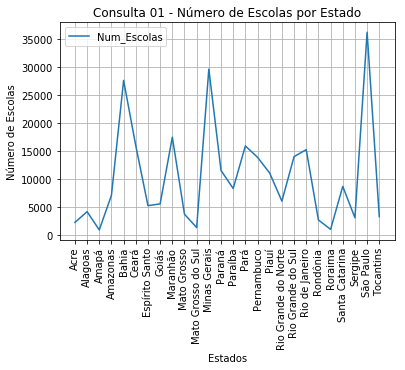

In [4]:
resultado = pandas.read_sql_query(consulta, conn)
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Num_Escolas)
ax.set(xlabel= 'Estados', ylabel='Número de Escolas', title='Consulta 01 - Número de Escolas por Estado')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta01.png")
plt.show()

#### 4.1.2 Consulta 2 (duas versões)

**Descrição:** Número de escolas por estado.

In [15]:
consulta = 'SELECT COUNT(*) FROM escola GROUP BY estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][1] = resultado.best

69.3 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
consulta_otimizada = 'SELECT COUNT(codigo) FROM escola GROUP BY estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][1] = resultado.best

80.3 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 4.2 Três Consultas Envolvendo *Junção* de Duas Relações

#### 4.2.1 Consulta 3 (duas versões)

**Descrição:** Etnias dos professores registrados no banco.

In [5]:
consulta = 'SELECT etnia AS Cod_Etnia, COUNT(*) AS Num_Professores FROM Docente GROUP BY etnia'
tempo_de_exec = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][2] = tempo_de_exec.best

4.22 s ± 62.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
consulta_otimizada = 'SELECT etnia AS Cod_Etnia, COUNT(*) AS Num_Professores FROM Docente GROUP BY etnia'
tempo_de_exec = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][2] = tempo_de_exec.best

4.16 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


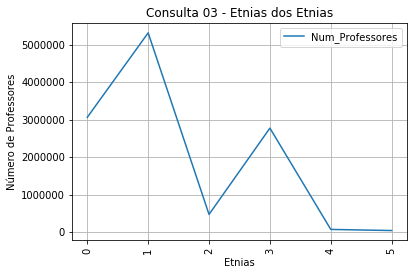

In [7]:
resultado = pandas.read_sql_query(consulta, conn)
resultado
fig, ax = plt.subplots()
ax.plot(resultado.Cod_Etnia, resultado.Num_Professores)
ax.set(xlabel= 'Etnias', ylabel='Número de Professores', title='Consulta 03 - Etnias dos Etnias')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta03.png")
plt.show()

#### 4.2.2 Consulta 4 (duas versões)

**Descrição:** Média de matrículas por estado.

In [18]:
consulta = 'SELECT Estado.nome AS Nome_Estado, AVG(qtdMatriculas) AS Media_Alunos_Turma FROM Turma ' + \
           'INNER JOIN Escola ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id ' + \
           'GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][3] = resultado.best

2.54 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado,' + \
                     'AVG(qtdMatriculas) AS Media_Alunos_Turma FROM Turma INNER JOIN Escola ON Turma.escola ' + \
                     '= Escola.codigo GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][3] = resultado.best

2.25 s ± 55.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


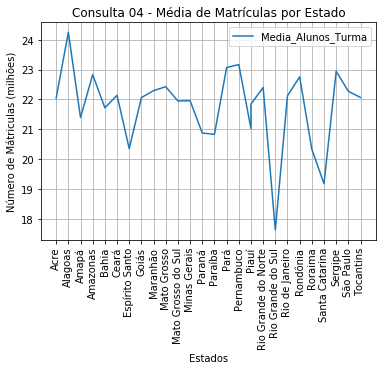

In [10]:
resultado = pandas.read_sql_query(consulta, conn)
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Media_Alunos_Turma)
ax.set(xlabel= 'Estados', ylabel='Número de Mátriculas (milhões)', title='Consulta 04 - Média de Matrículas por Estado')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta04.png")
plt.show()

#### 4.2.3 Consulta 5 (duas versões)

**Descrição:** Número de alunos em escolas da zona rural por estado.

In [21]:
consulta = 'SELECT Estado.nome AS Nome_Estado, SUM(qtdMatriculas) AS Num_Alunos FROM Turma INNER JOIN Escola ' + \
           'ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id INNER JOIN ' + \
           'PropriedadeEscola ON Escola.codigo = PropriedadeEscola.escola WHERE PropriedadeEscola.propriedade ' + \
           'IN (SELECT id FROM Propriedade WHERE codigo="ESCOLA_TP_LOCALIZACAO") AND valor =2 GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][4] = resultado.best

7.73 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado, ' + \
                     'SUM(qtdMatriculas) AS Num_Alunos FROM Turma INNER JOIN Escola ON Turma.escola = ' + \
                     'Escola.codigo WHERE Escola.codigo IN (SELECT escola FROM PropriedadeEscola WHERE ' + \
                     'propriedade in (SELECT id FROM Propriedade WHERE codigo="ESCOLA_TP_LOCALIZACAO")' + \
                     'AND valor =2)GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][4] = resultado.best

6.35 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


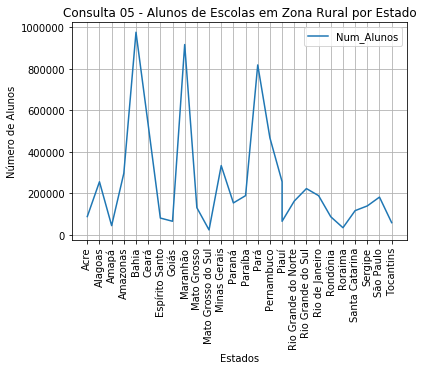

In [12]:
resultado = pandas.read_sql_query(consulta, conn)
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Num_Alunos)
ax.set(xlabel= 'Estados', ylabel='Número de Alunos', title='Consulta 05 - Alunos de Escolas em Zona Rural por Estado')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta05.png")
plt.show()

### 4.3 Três Consultas Envolvendo *Junção* de Três ou Mais Relações

#### 4.3.1 Consulta 6 (duas versões)

**Descrição:** Número de alunos matriculados por estado.

In [23]:
consulta = 'SELECT Estado.nome AS Nome_Estado, SUM(qtdMatriculas) AS Num_Alunos FROM Turma INNER JOIN Escola ' + \
           'ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][5] = resultado.best

2.54 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado,' + \
                     'SUM(qtdMatriculas) AS Num_Alunos FROM Turma INNER JOIN Escola ON Turma.escola = ' + \
                     'Escola.codigo GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][5] = resultado.best

2.23 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


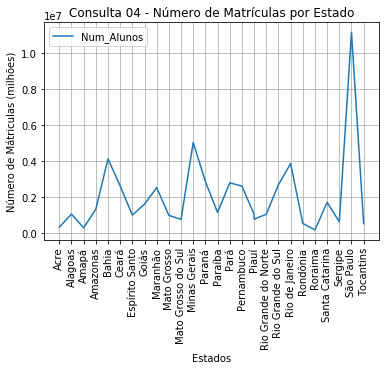

In [15]:
resultado = pandas.read_sql_query(consulta, conn)
resultado
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Num_Alunos)
ax.set(xlabel= 'Estados', ylabel='Número de Mátriculas (milhões)', title='Consulta 04 - Número de Matrículas por Estado')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta06.png")
plt.show()

#### 4.3.2 Consulta 7 (duas versões)

**Descrição:** Número de alunos da rede particular por estado na região 4.

In [25]:
consulta = 'SELECT Estado.nome AS Nome_Estado, SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ' + \
           'ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id INNER JOIN ' + \
           'PropriedadeEscola ON Escola.codigo = PropriedadeEscola.escola WHERE PropriedadeEscola.propriedade ' + \
           'IN (SELECT id FROM Propriedade WHERE codigo="ESCOLA_TP_DEPENDENCIA") AND valor = 4 ' + \
           'GROUP BY Escola.estado LIMIT 5'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][6] = resultado.best

7.22 s ± 234 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado, ' + \
                     'SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ON Turma.escola = ' + \
                     'Escola.codigo WHERE Escola.codigo IN (SELECT escola FROM PropriedadeEscola WHERE ' + \
                     'propriedade in (SELECT id FROM Propriedade WHERE codigo= ' + \
                     '"ESCOLA_TP_DEPENDENCIA") AND valor = 4)GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][6] = resultado.best

5.69 s ± 66.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


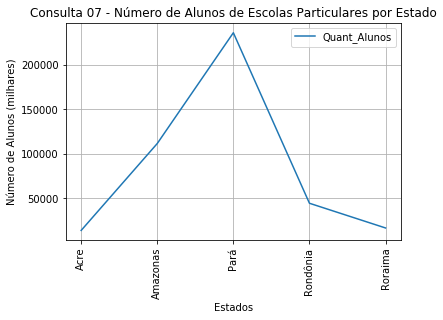

In [18]:
resultado = pandas.read_sql_query(consulta, conn)
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Quant_Alunos)
ax.set(xlabel= 'Estados', ylabel='Número de Alunos (milhares)', title='Consulta 07 - Número de Alunos de Escolas Particulares por Estado')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta07.png")
plt.show()

#### 4.3.3 Consulta 8 (duas versões)

**Descrição:** Número de professores por estado.

In [27]:
consulta = 'SELECT Estado.nome AS Nome_Estado, COUNT(*) AS Num_Docentes FROM Docente INNER JOIN Turma ON ' + \
           'Turma.codigo = Docente.turma INNER JOIN Escola ON Turma.escola = Escola.codigo INNER JOIN Estado ' + \
           'ON Escola.estado = Estado.id GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][7] = resultado.best

17.3 s ± 1.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado, ' + \
                     'COUNT(Docente.codigo) AS Num_Docentes FROM Docente INNER JOIN Turma ON Turma.codigo = ' + \
                     'Docente.turma INNER JOIN Escola ON Turma.escola = Escola.codigo GROUP BY Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][7] = resultado.best

17.8 s ± 335 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 4.4 Duas Consultas Envolvendo *Agregação* sobre *Junção* de Duas ou Mais Relações

#### 4.4.1 Consulta 9 (duas versões)

**Descrição:** Número de alunos em escolas sem energia elétrica.

In [29]:
consulta = 'SELECT Estado.nome AS Nome_Estado, SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ' + \
           'ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id INNER JOIN ' + \
           'PropriedadeEscola ON Escola.codigo = PropriedadeEscola.escola WHERE PropriedadeEscola.propriedade ' + \
           'IN (SELECT id FROM Propriedade WHERE codigo="ESCOLA_IN_ENERGIA_INEXISTENTE") AND valor = 1 GROUP BY ' + \
           'Escola.estado'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][8] = resultado.best

7.38 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado, ' + \
                     'SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ON Turma.escola = ' + \
                     'Escola.codigo WHERE Escola.codigo IN (SELECT escola FROM PropriedadeEscola ' + \
                     'WHERE propriedade in (SELECT id FROM Propriedade WHERE codigo="ESCOLA_IN_ENERGIA_INEXISTENTE")' + \
                     'AND valor = 1) GROUP BY Escola.estado LIMIT 5'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][8] = resultado.best

5.47 s ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


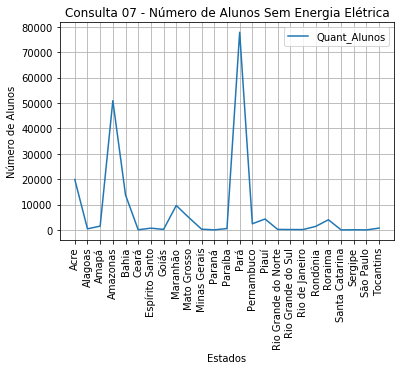

In [31]:
resultado = pandas.read_sql_query(consulta, conn)
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Quant_Alunos)
ax.set(xlabel= 'Estados', ylabel='Número de Alunos', title='Consulta 07 - Número de Alunos Sem Energia Elétrica')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta09.png")
plt.show()

#### 4.4.2 Consulta 10 (duas versões)

**Descrição:** Número de Alunos em Escolas sem Abastecimento de Água

In [32]:
consulta = 'SELECT Estado.nome AS Nome_Estado, SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ' + \
           'ON Turma.escola = Escola.codigo INNER JOIN Estado ON Escola.estado = Estado.id INNER JOIN ' + \
           'PropriedadeEscola ON Escola.codigo = PropriedadeEscola.escola WHERE PropriedadeEscola.propriedade ' + \
           'IN (SELECT id FROM Propriedade WHERE codigo="ESCOLA_IN_AGUA_INEXISTENTE") AND valor = 1 GROUP BY ' + \
           'Escola.estado LIMIT 5'
resultado = %timeit -o pandas.read_sql_query(consulta, conn)
tempo_gasto[0][9] = resultado.best

7.4 s ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
consulta_otimizada = 'SELECT (SELECT Estado.nome FROM Estado Where Estado.id = Escola.estado) AS Nome_Estado, ' + \
                     'SUM(qtdMatriculas) AS Quant_Alunos FROM Turma INNER JOIN Escola ON Turma.escola = ' + \
                     'Escola.codigo WHERE Escola.codigo IN (SELECT escola FROM PropriedadeEscola WHERE ' + \
                     'propriedade in (SELECT id FROM Propriedade WHERE codigo="ESCOLA_IN_AGUA_INEXISTENTE") ' + \
                     'AND valor = 1) GROUP BY Escola.estado LIMIT 5'
resultado = %timeit -o pandas.read_sql_query(consulta_otimizada, conn)
tempo_gasto[1][9] = resultado.best

5.41 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


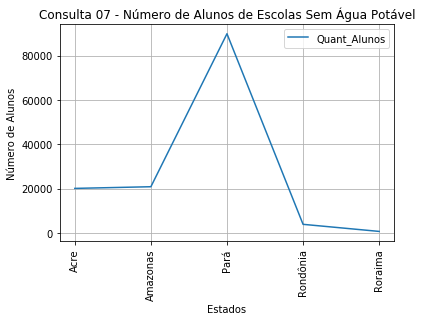

In [34]:
resultado = pandas.read_sql_query(consulta, conn)
resultado = resultado.sort_values(by=['Nome_Estado'])
fig, ax = plt.subplots()
ax.plot(resultado.Nome_Estado, resultado.Quant_Alunos)
ax.set(xlabel= 'Estados', ylabel='Número de Alunos', title='Consulta 07 - Número de Alunos de Escolas Sem Água Potável')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.grid()
plt.legend()
fig.savefig("consulta10.png")
plt.show()

## 5. Análise de Performance

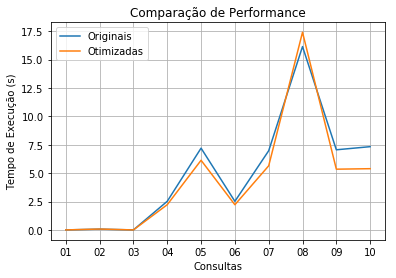

In [35]:
fig, ax = plt.subplots()
ax.plot(rotulos, tempo_gasto[0], label='Originais')
ax.plot(rotulos, tempo_gasto[1], label='Otimizadas')

ax.set(xlabel= 'Consultas', ylabel='Tempo de Execução (s)', title='Comparação de Performance')
ax.grid()
plt.legend()
fig.savefig("performance.png")
plt.show()

## 6. Autoavaliação dos Membros

* **Fernanda:** Realizou a criação do notebook python, o agrupamentos dos resultados e a elaboração dos gráficos. 18/15.
* **Ketlyn:** Em conjunto com o grupo definiu as consultas, em seguida as implementou e otimizou. 18/15.
* **Michelle:** Estudou o formato dos dados, esboçou o esquema ER e relacional, extraiu os dados CSV para o SQL, gerando um banco de aproximadamente 50gb. 18/15